### 4.2. XGBoost 预测

predict 函数：取 2020-01-11 到 last_date 之间的各种数据，使用前 n - 1 天的数据训练并预测各地最后一天的新增确诊人数。

In [26]:
from coronavirus_analyzer import CoronavirusAnalyzer
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb

def predict(last_date, use_move=True, use_ma3=False, use_in_out_rate=True, use_day_idx=True, 
            use_move_in_inc_rate=False, use_weather=False, omit_hubei=True, selected_regions=None):
    '''
    last_date               加载数据的最后一天
    use_move                是否使用人流数据，函数中 use_data 是算法使用的数据
    use_ma3                 是否使用前3天（不含当天）新增确诊人数均值，函数中 use_data 是算法使用的数据
    use_in_out_rate         各地 1天前的人流进出比例
    use_weather             是否使用天气数据，函数中 use_data 是算法使用的数据
    omit_hubei              是否忽略湖北
    selected_regions        只学习和预测某些地区，如果为 None，表示都学习和预测
    
    use_move_in_inc_rate 同时启用，会有河南、江西 2020-01-01 预测的严重错误
    '''
    omitted_regions = ['湖北'] if omit_hubei else []
    
    analyzer = CoronavirusAnalyzer(last_date)
    
    df_virus_daily_inc_injured = analyzer.del_city_special_regions(analyzer.df_virus_daily_inc_injured)
    df_move_in_injured = analyzer.del_city_regions(analyzer.df_move_in_injured)
    df_move_in_injured_2 = analyzer.del_city_regions(analyzer.get_df_move_in_injured(2))
    df_move_in_injured_3 = analyzer.del_city_regions(analyzer.get_df_move_in_injured(3))
    df_move_in_injured_4 = analyzer.del_city_regions(analyzer.get_df_move_in_injured(4))
    df_move_in_injured_5 = analyzer.del_city_regions(analyzer.get_df_move_in_injured(5))
    df_weather_ma = analyzer.del_city_special_regions(analyzer.df_weather_ma)
    df_virus_7_days = analyzer.del_city_special_regions(analyzer.df_virus_7_days_inc_injured)
    df_daily_inc_ma3 = analyzer.moving_avg(analyzer.df_virus_daily_inc_injured, window=3, 
                                           shift=1, keep_shape=True).fillna(0)
    df_curve_in_out_rate = analyzer.df_curve_in_out_rate
    df_move_in_injured_inc_rate_1 = analyzer.get_df_move_in_injured_inc_rate(1)
    df_move_in_injured_inc_rate_2 = analyzer.get_df_move_in_injured_inc_rate(2)
    df_move_in_injured_inc_rate_3 = analyzer.get_df_move_in_injured_inc_rate(3)
    df_move_in_injured_inc_rate_4 = analyzer.get_df_move_in_injured_inc_rate(4)
    df_move_in_injured_inc_rate_5 = analyzer.get_df_move_in_injured_inc_rate(5)
    
    # 自然数日期
    df_day_idx = analyzer.get_df_day_idx(df_move_in_injured)
    # 1 级列索引转 2 级列索引
#     if not isinstance(df_move_in_injured.columns, pd.MultiIndex):
    df_day_idx.columns = pd.MultiIndex.from_product(
        [df_day_idx.columns, ['天数']])
    df_move_in_injured.columns = pd.MultiIndex.from_product(
        [df_move_in_injured.columns, ['1天前人流风险系数']])
    df_move_in_injured_2.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_2.columns, ['2天前人流风险系数']])
    df_move_in_injured_3.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_3.columns, ['3天前人流风险系数']])
    df_move_in_injured_4.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_4.columns, ['4天前人流风险系数']])
    df_move_in_injured_5.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_5.columns, ['5天前人流风险系数']])
    df_move_in_injured_inc_rate_1.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_inc_rate_1.columns, ['风险系数1日增长趋势']])
    df_move_in_injured_inc_rate_2.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_inc_rate_2.columns, ['风险系数2日增长趋势']])
    df_move_in_injured_inc_rate_3.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_inc_rate_3.columns, ['风险系数3日增长趋势']])
    df_move_in_injured_inc_rate_4.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_inc_rate_4.columns, ['风险系数4日增长趋势']])
    df_move_in_injured_inc_rate_5.columns = pd.MultiIndex.from_product(
        [df_move_in_injured_inc_rate_5.columns, ['风险系数5日增长趋势']])
    df_daily_inc_ma3.columns = pd.MultiIndex.from_product(
        [df_daily_inc_ma3.columns, ['3日新增均值']])
    df_curve_in_out_rate.columns = pd.MultiIndex.from_product(
        [df_curve_in_out_rate.columns, ['进出比例']])
    # index 统一从 2020-01-11 到 last_date，并合并 4 个 DataFrame
    index = df_move_in_injured.index
    dfs = []
    
    
    # 所有使用的数据 list
    use_data = [df_virus_7_days]  # 自然人天数和各地 1天前、2天前、......、7天前的每日新增确诊人数，一定会使用
    if use_day_idx:
        # 自然数日期
        use_data.append(df_day_idx)
    if use_weather:
        # 各地 14天前、13天前、......、3天前的天气滑动加权平均数据，权重值为 1,2,3,4,5,6,7,8,9,10,9,8
        use_data.append(df_weather_ma)
    if use_move:
        use_data.append(df_move_in_injured)
        use_data.append(df_move_in_injured_2)
        use_data.append(df_move_in_injured_3)
        use_data.append(df_move_in_injured_4)
        use_data.append(df_move_in_injured_5)
        # 各地 7 天内（不含当天，即 1天前到7天前，的所有确诊人数作为权重 * 进入该地区的人流规模）
    if use_ma3:
        # 各地 1天前、2天前、3天前 每日新增均值
        use_data.append(df_daily_inc_ma3)
    if use_in_out_rate:
        # 各地 1天前的人流进出比例
        use_data.append(df_curve_in_out_rate)
    if use_move_in_inc_rate:
        # 各地风险系数增长趋势
        use_data.append(df_move_in_injured_inc_rate_1)
        use_data.append(df_move_in_injured_inc_rate_2)
        use_data.append(df_move_in_injured_inc_rate_3)
#         use_data.append(df_move_in_injured_inc_rate_5)
    for df in use_data:
        for region in omitted_regions:
            try:
                del df[region]
            except:
                pass
        if df.shape[0] != index.size:
            df = df.reindex(index)
        dfs.append(df)
    df_trait = pd.concat(dfs, axis=1, sort=False)
    
#     try:
#         print('============== {}'.format(df_trait.columns))
    df_trait = df_trait.sort_index(axis=1)
#     except:
#         print('============== except')
    
    
    df_X_train = df_trait.iloc[:-1]
#     df_y_train = df_virus_daily_inc_injured.iloc[:-1]
    df_y_train = df_virus_daily_inc_injured.iloc[:df_X_train.shape[0]]
    df_X_test = df_trait.iloc[-1:]
    df_y_test = df_virus_daily_inc_injured.iloc[-1:]
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    regions = []
    for region in df_y_train.columns:
        if selected_regions is not None and region not in selected_regions:
            continue
        if region not in omitted_regions:
            regions.append(region)
            arr_X_train = df_X_train[region].values
            arr_y_train = df_y_train[region].values
            arr_X_test = df_X_test[region].values
            arr_y_test = df_y_test[region].values
            if X_train is None:
                X_train = arr_X_train
                y_train = arr_y_train
                X_test = arr_X_test
                y_test = arr_y_test
            else:
                X_train = np.vstack([X_train, arr_X_train])
                y_train = np.hstack([y_train, arr_y_train])
                X_test = np.vstack([X_test, arr_X_test])
                y_test = np.hstack([y_test, arr_y_test])
#     print(X_train.shape, y_train.shape)
    region_cnt = len(regions)

    min_err_rate = 1
    min_err_sum = 1000000
    best_objective = best_max_depth = best_n_estimators = best_learning_rate = None
    objectives = ['reg:gamma']  # 'reg:squarederror', 'count:poisson', 
    for objective in objectives:
#         print('*' * 40, objective, '*' * 40)
        for max_depth in range(12, 13, 2):  # (10, 16):
#             print('max_depth: {}'.format(max_depth))
            for n_estimators in range(240, 250, 30):  # (100, 210, 10):
        #         print('n_estimators: {}'.format(n_estimators))
                for learning_rate in range(10, 11):
                    learning_rate = learning_rate / 100
                    model = xgb.XGBRegressor(
                        max_depth=max_depth, 
                        learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        objective=objective)
                    model.fit(X_train, y_train)
                    
                    df_predict = pd.DataFrame(np.array([model.predict(X_test), y_test]).T, 
                                              index=regions, columns=['预测', '实际'])
                    df_predict['预测差'] = df_predict['预测'] - df_predict['实际']
                    df_predict['预测误差百分比'] = df_predict['预测差'] / df_predict['实际']
                    df_predict['预测误差百分比'][df_predict['实际'].values == 0] = 0
                    df_predict['权重'] = region_cnt * df_predict['实际'] / df_predict['实际'].sum()
                    df_predict['加权预测误差百分比'] = df_predict['预测误差百分比'] * df_predict['权重']
                    err_rate = abs(df_predict['加权预测误差百分比'].values).sum() / region_cnt
                    err_sum = abs(df_predict['预测差'].values).sum()
                    if err_rate < min_err_rate or err_sum < min_err_sum:
    #                     print('max_depth：{}，n_estimators：{}，learning_rate：{}，加权预测误差绝对值的均值：{}，'\
    #                           '最小误差绝对值总和为：{}。'
    #                           .format(max_depth, n_estimators, learning_rate, err_rate, err_sum))
                        if min_err_rate > err_rate:
                            min_err_rate = err_rate
                            min_err_sum = err_sum
                            best_max_depth = max_depth
                            best_n_estimators = n_estimators
                            best_learning_rate = learning_rate
                            best_objective = objective
    print('best_objective：{}，best_max_depth：{}，best_n_estimators：{}，best_learning_rate：{}，'\
          '加权预测误差绝对值的均值：{}，最小误差绝对值总和为：{}。'
          .format(best_objective, best_max_depth, best_n_estimators, best_learning_rate, min_err_rate, min_err_sum))

#     print(best_max_depth, best_learning_rate, best_n_estimators, best_objective)
    model = xgb.XGBRegressor(
        max_depth=best_max_depth,
        learning_rate=best_learning_rate,
        n_estimators=best_n_estimators,
        objective=best_objective)
    model.fit(X_train, y_train)
    
    
    from matplotlib import pyplot
    pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
    pyplot.show()
    l = [for x in df_trait.columns.levels[1].tolist()]
    
#     analyzer = CoronavirusAnalyzer()
#     analyzer.df_virus_daily_inc_injured.loc[last_date]
    
    df_predict = pd.DataFrame(np.array([model.predict(X_test), y_test]).T, 
                              index=regions, columns=['预测', '实际'])
    
    # 预测时候，输入的预测所需数据，是没有预测当天的，所以这里把实际新增人数重新加载一下当天的，并覆盖
    df_real_inc = CoronavirusAnalyzer(str(datetime.date.today())).df_virus_daily_inc_injured
    df_predict['实际'] = df_real_inc.loc[last_date][regions]
    
    df_predict['预测差'] = df_predict['预测'] - df_predict['实际']
    df_predict['预测误差百分比'] = df_predict['预测差'] / df_predict['实际']
    df_predict['预测误差百分比'][df_predict['实际'].values == 0] = 0
    df_predict['权重'] = region_cnt * df_predict['实际'] / df_predict['实际'].sum()
    df_predict['加权预测误差百分比'] = df_predict['预测误差百分比'] * df_predict['权重']
    err_rate = abs(df_predict['加权预测误差百分比'].values).sum() / region_cnt
    
    err_percent_sum = df_predict['预测误差百分比'].values.sum()
    err_sum = df_predict['预测差'].values.sum()
    err_abs_sum = abs(df_predict['预测差'].values).sum()
    print('预测：{}，预测误差百分比总和：{}，预测差总和：{}，预测差绝对值的总和：{}，加权预测误差绝对值的均值：{}'
          .format(last_date, err_percent_sum, err_sum, err_abs_sum, err_rate))
    df_predict = df_predict.sort_values('实际', ascending=False)
    return df_predict

2020-02-05 16:24:26,949 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。


['1天前', '1天前人流风险系数', '2天前', '2天前人流风险系数', '3天前', '3天前人流风险系数', '4天前', '4天前人流风险系数', '5天前', '5天前人流风险系数', '6天前', '7天前', '天数', '进出比例']
best_objective：reg:gamma，best_max_depth：12，best_n_estimators：240，best_learning_rate：0.1，加权预测误差绝对值的均值：0.18400082723149716，最小误差绝对值总和为：136.53304629819468。


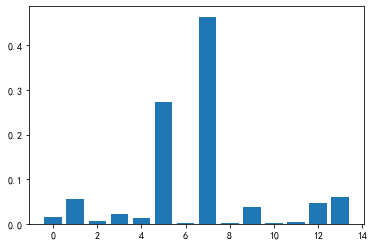

2020-02-05 16:24:41,258 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。


[('上海', '1天前'), ('上海', '1天前人流风险系数'), ('上海', '2天前'), ('上海', '2天前人流风险系数'), ('上海', '3天前'), ('上海', '3天前人流风险系数'), ('上海', '4天前'), ('上海', '4天前人流风险系数'), ('上海', '5天前'), ('上海', '5天前人流风险系数'), ('上海', '6天前'), ('上海', '7天前'), ('上海', '天数'), ('上海', '进出比例'), ('云南', '1天前'), ('云南', '1天前人流风险系数'), ('云南', '2天前'), ('云南', '2天前人流风险系数'), ('云南', '3天前'), ('云南', '3天前人流风险系数'), ('云南', '4天前'), ('云南', '4天前人流风险系数'), ('云南', '5天前'), ('云南', '5天前人流风险系数'), ('云南', '6天前'), ('云南', '7天前'), ('云南', '天数'), ('云南', '进出比例'), ('内蒙古', '1天前'), ('内蒙古', '1天前人流风险系数'), ('内蒙古', '2天前'), ('内蒙古', '2天前人流风险系数'), ('内蒙古', '3天前'), ('内蒙古', '3天前人流风险系数'), ('内蒙古', '4天前'), ('内蒙古', '4天前人流风险系数'), ('内蒙古', '5天前'), ('内蒙古', '5天前人流风险系数'), ('内蒙古', '6天前'), ('内蒙古', '7天前'), ('内蒙古', '天数'), ('内蒙古', '进出比例'), ('北京', '1天前'), ('北京', '1天前人流风险系数'), ('北京', '2天前'), ('北京', '2天前人流风险系数'), ('北京', '3天前'), ('北京', '3天前人流风险系数'), ('北京', '4天前'), ('北京', '4天前人流风险系数'), ('北京', '5天前'), ('北京', '5天前人流风险系数'), ('北京', '6天前'), ('北京', '7天前'), ('北京', '天数'), ('北京', '进出比例'), ('吉林', '1天前'), ('吉林', '1天

In [27]:
# [1] 32 19 29 [2] 32 18 28 [3] 27 18 30 [1&3] 26 22 28\22 22 28
# 38 21 27 | 37 21 27 | 25 19 29 | 33 26 26 | 22 17 31 | 19 20 30 | 17 19 31 | 22 20 31
import datetime
date = datetime.date(2020, 2, 5)
dfs_predict = {}
while date <= datetime.date.today():
    str_date = str(date)
    dfs_predict[str_date] = predict(str_date)
    date += datetime.timedelta(days=1)

In [17]:
import pandas as pd
import numpy as np
dfs = []
for date in sorted(list(dfs_predict.keys())):
    df = dfs_predict[date]
    df = df[['预测', '实际']]
    df.columns = ['{}预测'.format(date)[5:], '{}实际'.format(date)[5:]]
    dfs.append(df)
df = pd.concat(dfs, axis=1, sort=False)
df *= 1000000
df = df.astype(np.int32)
df = df.astype(np.float32)
df /= 1000000
df.iloc[:, :-1]

,02-01预测,02-01实际,02-02预测,02-02实际,02-03预测,02-03实际,02-04预测,02-04实际,02-05预测
广东,100.582728,84.0,70.995208,79.0,67.379832,114.0,72.938320,73.0,79.146136
湖南,57.603024,74.0,68.242488,58.0,58.508156,72.0,65.868620,68.0,72.759360
河南,68.467120,71.0,70.912344,73.0,72.045744,109.0,84.976736,89.0,82.829112
浙江,83.187152,62.0,65.549620,63.0,78.885136,105.0,94.520720,66.0,80.602232
江西,50.272636,47.0,50.708092,58.0,47.453680,85.0,74.288112,72.0,69.727488
安徽,54.166856,43.0,51.111500,68.0,59.158216,72.0,60.181952,50.0,81.226232
江苏,32.433884,34.0,31.206314,35.0,37.967416,37.0,34.914384,33.0,29.430876
北京,11.637272,27.0,14.367537,29.0,25.622232,16.0,17.602492,25.0,17.746428
重庆,32.951588,24.0,27.086412,38.0,49.736984,37.0,39.776364,29.0,33.841584
四川,21.790368,24.0,19.225184,23.0,31.202904,28.0,24.627750,19.0,21.546252


In [19]:
import pandas as pd
import numpy as np
dfs = []
for date in sorted(list(dfs_predict.keys())):
    df = dfs_predict[date]
    df = df[['预测', '实际']]
    df.columns = ['{}预测'.format(date)[5:], '{}实际'.format(date)[5:]]
    dfs.append(df)
df = pd.concat(dfs, axis=1, sort=False)
df *= 1000000
df = df.astype(np.int32)
df = df.astype(np.float32)
df /= 1000000
df = df.iloc[:, :-1]
df.to_csv('预测2020-02-05.csv')

In [4]:
def analyze_predict(dfs_predict):
    print('每日新增预测说明：除了港澳台、湖北外的省、直辖市，下一日新增确诊人数预测，'
          '2020-02-04 表示从 2020-02-04 凌晨 到 2020-02-05 凌晨之间新增人数。'
          '数据采集自丁香医生网每天各地每天第一条确诊人数变化的数据。')
    pd.set_option('max_colwidth',100)
    dfs = []
    for date in sorted(list(dfs_predict.keys())):
        df = dfs_predict[date][['预测', '实际']]
        df.columns = pd.MultiIndex.from_product([[date], df.columns])
        dfs.append(df)
    df = pd.concat(dfs, axis=1, sort=False)
    df = df * 100000
    df = df.astype(np.int32)
    df = df.astype(np.float32)
    df = df / 100000
    df = df.iloc[:, [1, 2]]
    # df.loc[:('2020-02-04', 'a')] = df.iloc[1] - df.iloc[0]
    df.columns = ['2020-02-03实际', '2020-02-04预测']
    mask = df.iloc[:, 1] - df.iloc[:, 0]
    l = []
    for m in mask.values:
        if m < 0:
            l.append('降')
        elif m == 0:
            l.append('平')
        else:
            l.append('升')
    df['相比前日'] = l
    return df

In [28]:
from coronavirus_analyzer import CoronavirusAnalyzer
import pandas as pd
import datetime

df = pd.read_csv('预测记录.csv', index_col=0)
dates = ['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04']
for date in dates:
    analyzer = CoronavirusAnalyzer(str(datetime.date.today()))
    df_inc_injured = analyzer.df_virus_daily_inc_injured
    s_inc_injured = df_inc_injured.loc[date]
    # df.to_csv('预测记录.csv')
    s = s_inc_injured[df.index]
    df['{}实际'.format(date)] = s
cols = []
for date in dates:
    for name in ['预测', '实际']:
        col = '{}{}'.format(date, name)
        if col in df.columns:
            cols.append(col)
df = df[cols]
df

2020-02-05 13:56:18,106 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。
2020-02-05 13:56:18,283 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。
2020-02-05 13:56:18,476 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。
2020-02-05 13:56:18,706 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-05），如下这些地区没有新增的确诊人数：宁夏、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：宁夏、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。


,2020-02-01实际,2020-02-02实际,2020-02-03实际,2020-02-04预测,2020-02-04实际
地区,,,,,
浙江,62.0,63.0,105.0,93.21434,66.0
广东,84.0,79.0,114.0,77.07632,73.0
河南,71.0,73.0,109.0,87.58338,89.0
湖南,74.0,58.0,72.0,66.58438,68.0
江西,47.0,58.0,85.0,73.04395,72.0
安徽,43.0,68.0,72.0,61.57118,50.0
重庆,24.0,38.0,37.0,41.50994,29.0
江苏,34.0,35.0,37.0,39.07899,33.0
四川,24.0,23.0,28.0,25.18164,19.0


In [18]:
analyzer.df_virus_daily_inc_injured

,全国,武汉,湖北,浙江,广东,河南,湖南,江西,安徽,重庆,...,甘肃,吉林,内蒙古,宁夏,新疆,香港,青海,台湾,澳门,西藏
2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-17,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-18,59.0,59.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19,77.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-20,121.0,60.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
analyze_predict(dfs_predict)
dfs_predict['2020-02-04']

每日新增预测说明：除了港澳台、湖北外的省、直辖市，下一日新增确诊人数预测，2020-02-04 表示从 2020-02-04 凌晨 到 2020-02-05 凌晨之间新增人数。数据采集自丁香医生网每天各地每天第一条确诊人数变化的数据。


,预测,实际,预测差,预测误差百分比,权重,加权预测误差百分比
河南,8.409148e+01,89.0,-4.908516e+00,-0.055152,8.066465,-0.444881
安徽,6.095695e+01,50.0,1.095695e+01,0.219139,4.531722,0.993077
重庆,4.013914e+01,29.0,1.113914e+01,0.384108,2.628399,1.009589
山东,2.472759e+01,28.0,-3.272411e+00,-0.116872,2.537764,-0.296593
上海,1.277199e+01,25.0,-1.222801e+01,-0.489120,2.265861,-1.108279
河北,1.230798e+01,22.0,-9.692024e+00,-0.440547,1.993958,-0.878431
四川,2.606511e+01,19.0,7.065105e+00,0.371848,1.722054,0.640342
广东,6.415849e+01,16.0,4.815849e+01,3.009906,1.450151,4.364818
吉林,3.997147e+00,12.0,-8.002853e+00,-0.666904,1.087613,-0.725334
广西,1.450633e+01,11.0,3.506330e+00,0.318757,0.996979,0.317794


In [7]:
from coronavirus_analyzer import CoronavirusAnalyzer
analyzer = CoronavirusAnalyzer()
analyzer.df_virus_daily_inc_injured.iloc[-1]

2020-02-05 09:24:47,872 - CoronavirusAnalyzer - WARNING - 在最后一天（2020-02-04），如下这些地区没有新增的确诊人数：浙江、湖南、江西、北京、福建、陕西、内蒙古、宁夏、新疆、香港、台湾、澳门、西藏，如下这些地区没有任何疫情数据变化：内蒙古、宁夏、新疆、香港、台湾、澳门、西藏。请确保这些地区已经公布了最后一天的数据（一般是后面一天上午公布），否则分析出来的结果可能不准确。


全国     3492
武汉     1967
湖北     3156
浙江        0
广东       16
河南       89
湖南        0
安徽       50
江西        0
重庆       29
江苏       33
四川       19
山东       28
上海       25
北京        0
福建        0
黑龙江      35
广西       11
陕西        0
河北       22
云南        5
辽宁        4
山西        7
海南        1
天津        1
贵州        8
甘肃        2
吉林       12
内蒙古       0
宁夏        0
新疆        0
香港        0
青海        2
台湾        0
澳门        0
西藏        0
Name: 2020-02-04, dtype: int32